# Unit 5 - Financial Planning

In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import json

%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [3]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [4]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=USD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=USD"

In [5]:
# Fetch current BTC price
btc_url = btc_url + "?format=json"
# Request btc data
btc_data = requests.get(btc_url).json()
btc_price = btc_data['data']['1']['quotes']['USD']['price']

# Fetch current ETH price
eth_url = eth_url + "?format=json"
# Request eth data
eth_data = requests.get(eth_url).json()
eth_price = eth_data['data']['1027']['quotes']['USD']['price']

# Compute current value of my crpto
my_btc_value = btc_price * my_btc
my_eth_value = eth_price * my_eth

# # Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $28248.00
The current value of your 5.3 ETH is $9855.03


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [6]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [7]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_TRADE_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2"
)
    

In [8]:
# Format current date as ISO format
today = pd.Timestamp("2022-08-17", tz="America/New_York").isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Get current closing prices for SPY and AGG
portfolio_df = alpaca.get_bars(
    tickers,
    timeframe,
    start = today,
    end = today
).df

## Make sure portfolio_df get_bars displays properly:
## portfolio_df.head()

# Reorganize the DataFrame
# Separate ticker data
AGG = portfolio_df[portfolio_df['symbol']=='AGG'].drop('symbol', axis=1)
SPY = portfolio_df[portfolio_df['symbol']=='SPY'].drop('symbol', axis=1)

# Concatenate the ticker DataFrames
portfolio_df = pd.concat([AGG, SPY], axis=1, keys=['AGG','SPY'])

# Preview DataFrame
portfolio_df

AGG                                    \
                             open     high     low   close   volume   
timestamp                                                             
2022-08-17 04:00:00+00:00  102.64  102.735  102.34  102.49  7173838   

                                                      SPY                 \
                          trade_count        vwap    open   high     low   
timestamp                                                                  
2022-08-17 04:00:00+00:00       22030  102.512575  425.94  429.5  424.54   

                                                                     
                            close    volume trade_count        vwap  
timestamp                                                            
2022-08-17 04:00:00+00:00  426.65  63266564      451881  426.965059

In [9]:
# Pick AGG and SPY close prices
agg_close_price = float(portfolio_df["AGG"]["close"])
spy_close_price = float(portfolio_df["SPY"]["close"])

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $102.49
Current SPY closing price: $426.65


In [10]:
# Compute the current value of shares
my_spy_value = spy_close_price * my_spy
my_agg_value = agg_close_price * my_agg

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $21332.50
The current value of your 200 AGG shares is $20498.00


### Savings Health Analysis

In [11]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
my_crypto = my_btc_value + my_eth_value
my_shares = my_spy_value + my_agg_value

# Create savings DataFrame
total_amount = {'Amount': [my_crypto, my_shares]}
df_savings = pd.DataFrame(total_amount, index=["Crypto", "Shares"])

# Display savings DataFrame
display(df_savings)

,Amount
Crypto,38103.032
Shares,41830.500


<AxesSubplot:title={'center':'Amount of Savings in Crypto vs Shares'}, ylabel='Amount'>

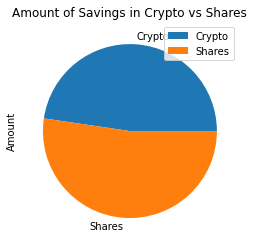

In [12]:
# Plot savings pie chart
df_savings.plot.pie(y="Amount", title="Amount of Savings in Crypto vs Shares")

In [13]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = my_crypto + my_shares

# Validate saving health
if total_savings > emergency_fund:
    difference = total_savings - emergency_fund
    print(f"Congrats! You're ${difference:0.2f} above your savings goal!")
elif total_savings == emergency_fund:
    print(f"Congrats! You're on par with your emergency fund!")
else:
    difference = emergency_fund - total_savings
    print(f"Oh no! You're $-{difference:0.2f} below your savings goal!")
        

Congrats! You're $43933.53 above your savings goal!


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [14]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2017-08-17', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2022-08-17', tz='America/New_York').isoformat()

In [23]:
# Get 5 years' worth of historical data for SPY and AGG
tickers = ["AGG", "SPY"]
df_stock_data = alpaca.get_bars(
    tickers,
    timeframe,
    start = start_date,
    end = end_date
).df

# Reorganize the DataFrame
# Separate ticker data
AGG_history = df_stock_data[df_stock_data['symbol']=='AGG'].drop('symbol', axis=1)
SPY_history = df_stock_data[df_stock_data['symbol']=='SPY'].drop('symbol', axis=1)


# Concatenate the ticker DataFrames
df_stock_data = pd.concat([AGG_history, SPY_history], axis=1, keys=['AGG','SPY'])

# Display sample data
display(df_stock_data.head())
# display(df_stock_data.tail())

AGG                                   \
                             open    high     low   close   volume   
timestamp                                                            
2017-08-17 04:00:00+00:00  109.83  110.02  109.78  110.02  5403527   
2017-08-18 04:00:00+00:00  110.05  110.14  109.89  109.95  1564794   
2017-08-21 04:00:00+00:00  110.01  110.09  109.97  110.03  1717640   
2017-08-22 04:00:00+00:00  109.99  110.02  109.87  109.93  1992321   
2017-08-23 04:00:00+00:00  110.08  110.19  110.01  110.18  1894934   

                                                      SPY                   \
                          trade_count        vwap    open     high     low   
timestamp                                                                    
2017-08-17 04:00:00+00:00       10956  109.943594  246.26  246.600  243.09   
2017-08-18 04:00:00+00:00        7827  109.993232  242.95  244.189  242.20   
2017-08-21 04:00:00+00:00        7688  110.029578  242.64  243.200  241.83   
2017-08-22 04:00:00+00:00        8252  109.929751  243.60  245.620  243.55   
2017-08-23 04:00:00+00:00       10186  110.092715  244.34  245.050  244.16   

                                                                      
                            close     volume trade_count        vwap  
timestamp                                                             
2017-08-17 04:00:00+00:00  243.09  128100396      428148  244.766670  
2017-08-18 04:00:00+00:00  242.71  136747986      389140  243.019365  
2017-08-21 04:00:00+00:00  242.90   65469736      231509  242.723675  
2017-08-22 04:00:00+00:00  245.44   63140101      225770  244.835231  
2017-08-23 04:00:00+00:00  244.56   50203837      162095  244.690966

In [16]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
# 252 trading days in a year--- multiply by 30
MC_even_dist = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.4,.6],
    num_simulation = 500,
    num_trading_days = 252*30
)


In [17]:
# Printing the simulation input data
MC_even_dist.portfolio_data.head()

AGG                                   \
                             open    high     low   close   volume   
timestamp                                                            
2017-08-17 04:00:00+00:00  109.83  110.02  109.78  110.02  5403527   
2017-08-18 04:00:00+00:00  110.05  110.14  109.89  109.95  1564794   
2017-08-21 04:00:00+00:00  110.01  110.09  109.97  110.03  1717640   
2017-08-22 04:00:00+00:00  109.99  110.02  109.87  109.93  1992321   
2017-08-23 04:00:00+00:00  110.08  110.19  110.01  110.18  1894934   

                                                                   SPY  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2017-08-17 04:00:00+00:00       10956  109.943594          NaN  246.26   
2017-08-18 04:00:00+00:00        7827  109.993232    -0.000636  242.95   
2017-08-21 04:00:00+00:00        7688  110.029578     0.000728  242.64   
2017-08-22 04:00:00+00:00        8252  109.929751    -0.000909  243.60   
2017-08-23 04:00:00+00:00       10186  110.092715     0.002274  244.34   

                                                                           \
                              high     low   close     volume trade_count   
timestamp                                                                   
2017-08-17 04:00:00+00:00  246.600  243.09  243.09  128100396      428148   
2017-08-18 04:00:00+00:00  244.189  242.20  242.71  136747986      389140   
2017-08-21 04:00:00+00:00  243.200  241.83  242.90   65469736      231509   
2017-08-22 04:00:00+00:00  245.620  243.55  245.44   63140101      225770   
2017-08-23 04:00:00+00:00  245.050  244.16  244.56   50203837      162095   

                                                    
                                 vwap daily_return  
timestamp                                           
2017-08-17 04:00:00+00:00  244.766670          NaN  
2017-08-18 04:00:00+00:00  243.019365    -0.001563  
2017-08-21 04:00:00+00:00  242.723675     0.000783  
2017-08-22 04:00:00+00:00  244.835231     0.010457  
2017-08-23 04:00:00+00:00  244.690966    -0.003585

In [18]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_even_dist.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/npamboukis/Desktop/Financial_Planner_API/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.001820,1.004507,1.000289,1.004676,0.998089,1.006270,1.012790,0.988527,1.010237,1.005877,...,0.983847,1.004081,0.993112,0.987392,0.997719,1.002260,0.997896,1.002994,0.989375,1.011289
2,1.027209,1.005411,0.988172,0.993110,0.991390,0.993322,1.007461,0.992836,1.008851,1.005411,...,0.972160,1.008558,0.986153,0.977846,0.975931,1.003654,0.996151,1.009287,0.996555,1.013190
3,1.030523,1.010174,0.984495,0.996954,0.990987,0.998010,0.999277,1.001620,1.009013,0.999247,...,0.966953,1.027067,0.997244,0.968151,0.979545,0.988599,0.993049,1.010983,0.992329,1.028294
4,1.035703,0.998317,0.969462,0.995436,0.989718,1.012852,0.997223,0.994124,1.008864,0.999949,...,0.979852,1.041316,1.004570,0.966897,0.972850,0.985856,0.991461,1.004038,0.990633,1.036965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,5.647868,14.718197,7.636844,6.355799,10.807311,4.837691,6.790419,11.428635,4.643277,15.588371,...,7.200312,6.508876,1.790027,10.356069,11.176578,6.524524,13.140383,9.368651,28.303959,9.992489
7557,5.572119,14.926383,7.640035,6.394416,10.864178,4.818296,6.762514,11.488177,4.661215,15.461676,...,7.185958,6.537941,1.797711,10.404640,11.019079,6.516736,13.100178,9.394389,28.176747,10.040238
7558,5.548531,14.854099,7.566424,6.436368,10.810091,4.812009,6.750679,11.513003,4.669226,15.367537,...,7.154086,6.516086,1.797881,10.409837,11.156694,6.549750,13.239721,9.284592,28.112326,10.059174
7559,5.567241,14.808261,7.475813,6.459811,10.883580,4.821993,6.763620,11.411910,4.682056,15.115272,...,7.190285,6.454654,1.798494,10.379272,11.139872,6.557176,13.279827,9.251367,28.574216,10.013831


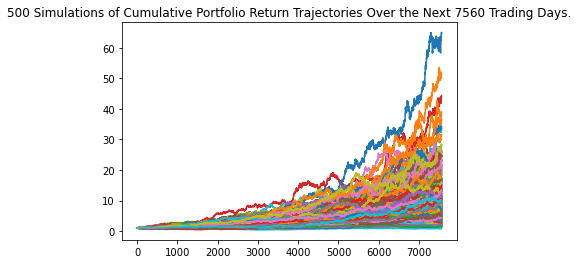

In [24]:
# Plot simulation outcomes
line_plot = MC_even_dist.plot_simulation()

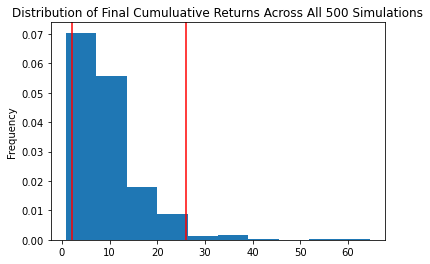

In [25]:
# Plot probability distribution and confidence intervals
dist_plot = MC_even_dist.plot_distribution()

### Retirement Analysis

In [29]:
# Fetch summary statistics from the Monte Carlo simulation results
even_tbl = MC_even_dist.summarize_cumulative_return()

# Print summary statistics
print(even_tbl)


count           500.000000
mean              9.557536
std               7.147937
min               0.787316
25%               4.960296
50%               7.693254
75%              11.781545
max              64.666550
95% CI Lower      2.068594
95% CI Upper     26.111316
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [30]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(even_tbl[8]*initial_investment,2)
ci_upper = round(even_tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $41371.87 and $522226.31


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [28]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(even_tbl[8]*initial_investment,2)
ci_upper = round(even_tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $62057.81 and $783339.47


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [31]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_even_dist = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.4,.6],
    num_simulation = 500,
    num_trading_days = 252*5
)


In [32]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_even_dist.calc_cumulative_return()


Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/npamboukis/Desktop/Financial_Planner_API/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.007694,1.001991,1.002194,0.998448,0.999854,0.998731,1.000107,1.002708,0.995799,0.998324,...,0.987233,0.999509,0.988534,1.007013,0.994599,0.994975,0.997596,0.999577,1.000241,0.996995
2,0.994855,1.010523,1.006190,1.006211,0.993646,1.004309,1.001217,1.000583,1.009782,0.997049,...,0.991317,0.991684,0.985505,0.992675,0.990407,0.983755,0.998747,1.005066,1.003650,0.999626
3,1.005918,1.011970,1.017927,1.004438,0.990418,1.006309,1.012612,1.011678,1.021858,1.006563,...,0.996689,0.999994,0.986098,0.987482,0.985559,0.974004,1.001231,1.002667,0.994297,0.987109
4,1.024163,1.002190,1.009443,0.989736,0.991716,1.018354,1.017382,0.997294,1.034088,1.004864,...,0.993368,1.015142,0.983476,0.978270,0.982327,0.973669,1.010357,0.996222,0.993190,0.990269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.393863,1.284898,1.329931,1.776860,1.655398,1.604248,1.541492,1.633101,1.275073,1.716665,...,2.356888,1.190315,1.018190,1.781961,1.237819,2.118855,1.133988,1.025835,2.467685,1.980347
1257,1.404097,1.289381,1.304883,1.783492,1.645739,1.597784,1.543651,1.638889,1.269923,1.730375,...,2.337885,1.180333,1.005023,1.794708,1.219636,2.146824,1.134496,1.034470,2.419423,1.997029
1258,1.391241,1.277378,1.289603,1.810542,1.634127,1.563936,1.559501,1.633875,1.261952,1.731905,...,2.315623,1.177562,1.023093,1.800915,1.206708,2.147079,1.126881,1.021576,2.406411,2.016838
1259,1.372809,1.268881,1.275084,1.829568,1.632905,1.555927,1.555280,1.638680,1.255015,1.744223,...,2.290506,1.175852,1.020979,1.812602,1.202683,2.150177,1.128741,1.018631,2.418467,2.038808


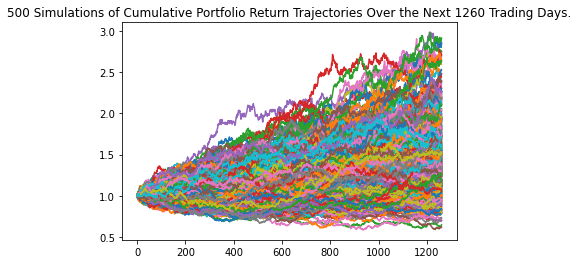

In [43]:
# Plot simulation outcomes
line_plot = MC_even_dist.plot_simulation()


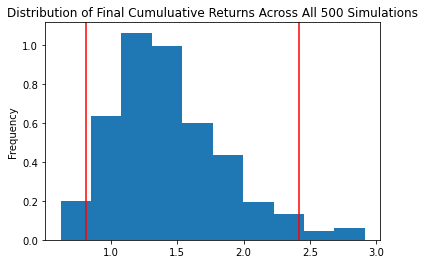

In [44]:
# Plot probability distribution and confidence intervals
dist_plot = MC_even_dist.plot_distribution()


In [45]:
# Fetch summary statistics from the Monte Carlo simulation results
even_tbl_five = MC_even_dist.summarize_cumulative_return()

# Print summary statistics
print(even_tbl_five)

count           500.000000
mean              1.437398
std               0.420586
min               0.621972
25%               1.134649
50%               1.363466
75%               1.643219
max               2.913021
95% CI Lower      0.814369
95% CI Upper      2.420482
Name: 1260, dtype: float64


In [48]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round(even_tbl_five[8]*initial_investment,2)
ci_upper_five = round(even_tbl_five[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 5 years will end within in the range of $16287.38 and $48409.64


### Ten Years Retirement Option

In [52]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_even_dist = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.4,.6],
    num_simulation = 500,
    num_trading_days = 252*10
)


In [53]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_even_dist.calc_cumulative_return()


Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/npamboukis/Desktop/Financial_Planner_API/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.001657,0.989589,0.999769,0.991714,0.996924,0.997754,1.013934,0.993580,0.990344,0.995393,...,1.003327,0.994992,1.009958,0.995359,1.010871,1.007451,0.996193,1.003607,0.997953,1.006481
2,0.996698,0.979813,0.998389,0.991587,0.992393,0.985030,1.023303,1.000260,1.001620,0.998447,...,0.995664,0.991635,1.001494,0.984259,1.008974,1.002598,0.998729,1.001330,0.990522,1.005561
3,0.991543,0.986138,0.995583,0.984848,0.996388,0.988770,1.006311,0.997018,1.001190,1.007376,...,0.998525,0.994277,1.007630,0.980845,1.016651,1.010645,0.999820,1.005988,0.993667,1.000493
4,0.989374,0.990068,0.990783,0.986491,0.999708,0.982276,1.011996,1.005150,0.987106,1.013275,...,0.994471,0.991255,1.009463,0.967895,1.006731,1.008445,0.996025,1.030351,0.998690,0.998857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,0.930746,1.441250,1.501368,2.039462,4.287967,1.481885,1.931259,2.180462,3.207115,4.494722,...,1.872156,1.310410,2.752455,2.083058,0.771456,1.838161,2.080822,1.371940,3.026870,4.775403
2517,0.938957,1.437594,1.491189,2.040485,4.295880,1.477423,1.923745,2.196741,3.230364,4.531011,...,1.874216,1.307123,2.725791,2.068938,0.762503,1.833341,2.096488,1.382160,3.034548,4.763763
2518,0.926169,1.452107,1.482829,2.076313,4.348636,1.489807,1.908123,2.169157,3.225988,4.544100,...,1.890405,1.312987,2.687088,2.064264,0.757747,1.860578,2.079751,1.397976,3.023988,4.782721
2519,0.931525,1.455049,1.466603,2.068510,4.303049,1.473829,1.927760,2.156454,3.235019,4.507743,...,1.917113,1.315626,2.697541,2.059348,0.756493,1.850420,2.075921,1.401906,3.017880,4.793433


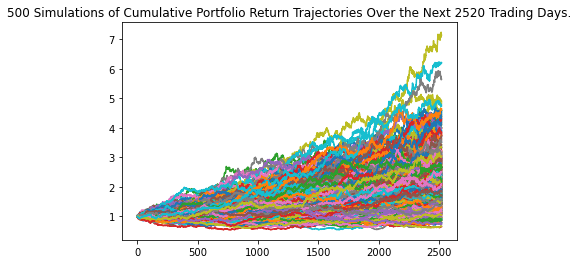

In [54]:
# Plot simulation outcomes
line_plot = MC_even_dist.plot_simulation()


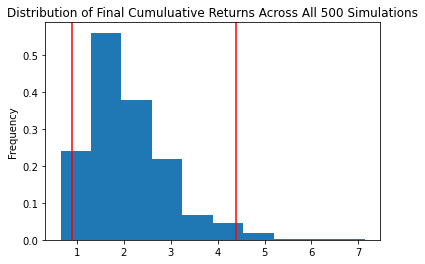

In [55]:
# Plot probability distribution and confidence intervals
dist_plot = MC_even_dist.plot_distribution()


In [56]:
# Fetch summary statistics from the Monte Carlo simulation results
even_tbl_ten = MC_even_dist.summarize_cumulative_return()

# Print summary statistics
print(even_tbl_ten)


count           500.000000
mean              2.112964
std               0.894719
min               0.656852
25%               1.470680
50%               1.931069
75%               2.537216
max               7.137127
95% CI Lower      0.890973
95% CI Upper      4.390944
Name: 2520, dtype: float64


In [57]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten = round(even_tbl_five[8]*initial_investment,2)
ci_upper_ten = round(even_tbl_five[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 10 years will end within in the range of $16287.38 and $48409.64
